(Threshold_Based_Metrics)=
# Threshold-based metrics

Fraud detection is most commonly addressed as a binary classification problem: A fraud detection system receives transactions, and its goal is to predict whether they are likely to be genuine, or fraudulent. Given a transaction $x$ (with features $x_1$, $x_2$, ...), a fraud detection system outputs a fraud score, and classifies it as genuine or fraudulent, as illustrated in Fig. 1. 

![](images/transaction_fraud_score_with_caption.png)

The fraud scores returned by a fraud detection system on a set of transactions only need to be *ordered*. The higher its value, the higher the probability for the transaction to be a fraud. For the sake of simplicity, we will assume in the following that the fraud score is the probability $p(x)$ for a transaction $x$ to be a fraud, that is, a value between 0 and 1.

The decision to classify a transaction as fraudulent can then be made by setting a threshold $0 \le t \le 1$ on the probability $p(x)$, such that if $p(x) > t$, the transaction is classified as fraudulent, or as genuine if $p(x) \le t$.

In [4]:
# Initialization: Load shared functions

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# For plotting confusion matrices
from pretty_plot_confusion_matrix import plot_confusion_matrix_from_data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37136  100 37136    0     0   533k      0 --:--:-- --:--:-- --:--:--  533k


In [22]:
# Getting classes from a vector of fraud probabilities and a threshold
def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    
    predicted_classes = [0 if fraud_probability<threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes

## Confusion matrix 


Once a threshold $t$ is set, the outcome of a binary classification problem is usually represented as a *confusion matrix*. Denoting by $Y_1$ the set of positive instances (frauds), $Y_0$ the set of negative instances (genuine), $\hat{Y}_1$ the set of instances predicted as positive and $\hat{Y}_0$ the ones predicted as negative, the confusion matrix is represented as follows, see Fig. 2 {cite}`tharwat2020classification,dal2015adaptive`.

![](images/confusion_matrix.png)
<div align="center">Fig. 2. Example of confusion matrix.</div>    

The four possible outcomes are

* TP: True positives. These are the instances of class 1 (fraudulent transactions), that the classifier correctly predicts as fraudulent.
* TN: True negatives. These are the instances of class 0 (genuine transactions), that the classifier correctly predicts as genuine.
* FP: False positives. These are the instances of class 0 (genuine transactions), that the classifier incorrectly predicts as fraudulent.
* FN: False negatives. These are the instances of class 1 (fraudulent transactions), that the classifier incorrectly predicts as genuine.

## Mean misclassification error

The most straightforward way to assess the performance of a binary classifier is by computing the proportion of misclassified instances. This quantity is known as the mean misclassification error (MME) and is computed as follows 

$$MME= \frac{FP+FN}{N}$$

where $N=TN+TP+FN+FP$ is the size of the dataset.

Note that the complementary $1-MME = \frac{TP+TN}{N}$ is sometimes used instead and referred to as the *accuracy score* (`sklearn.metrics.accuracy_score`). 


In [13]:
# Implementation of the mean misclassification error
def compute_MME(true_labels,predicted_classes):
    
    N = len(true_labels)
    
    MME = np.sum(np.array(true_labels)!=np.array(predicted_classes))/N
    
    return MME

The MME is usually a good indicator of a classifier performance for balanced datasets. For cost-sensitive problems such as fraud detection, the MME has several shortcomings. Let us illustrate this with the following example:

* 10 transactions
* 2 of which are fraudulent, and 8 of which are genuine
* The `true_labels` list gives the list of fraudulent (1) and genuine (0) labels
* The `fraud probabilities` list gives the fraud predictions from a fraud detection system



In [14]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]


And let us consider three thresholds:
    
* $t=1$: This threshold does not take into consideration the fraud probabilities, and classifies all transactions as genuine.
* $t=0.5$: This threshold is usually considered to be the *default* threshold, which assumes that a transaction with a fraud probability higher than 0.5 will be classified as fraud 
* $t=0.3$: Given the predicted fraud probabilities of this example, this threshold will allow to correctly classify the two fraudulent transactions

Let us plot the confusion matrix for these 3 thresholds:

In [15]:
%%capture

confusion_matrix_plots,ax=plt.subplots(1, 3, figsize=(17,4))

thresholds=[1,0.5,0.3]

for i in range(len(thresholds)):

    predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=thresholds[i])
    
    MME = compute_MME(true_labels,predicted_classes)
    
    confusion_matrix_plot = plot_confusion_matrix_from_data(true_labels, predicted_classes, columns=[0,1], 
                                                        annot=True, cmap="Oranges",
                                                          fmt='.2f', fz=12, lw=0.5, cbar=True, 
                                                        figsize=[4,4], show_null_values=1, 
                                                        pred_val_axis='lin',
                                                        subtitle="Threshold="+str(thresholds[i])+". MME="+str(MME),ax=ax[i])

plt.subplots_adjust(wspace=0.5)

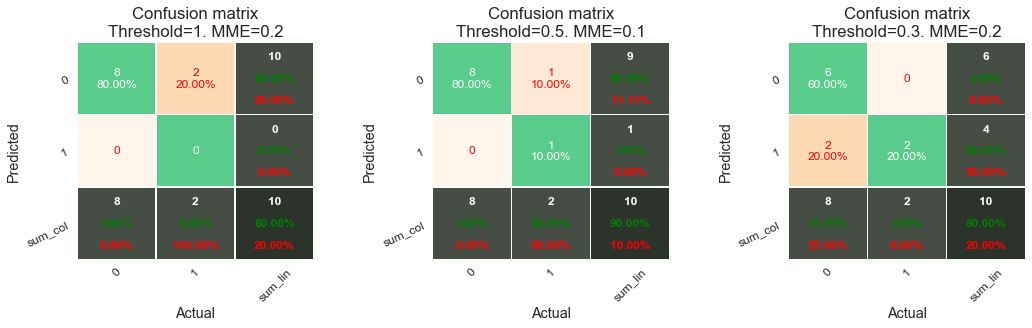

In [16]:
confusion_matrix_plots

Besides the confusion matrix, we also explicitly compute the MME and report it in the title. Note that the MME is also reported in red in the confusion matrix in the bottom-right cell, as a percentage. Let us now consider the results obtained with these three thresholds in more detail. 

* With a threshold $t=1$, all transactions are predicted as genuine. The classifier makes two mistakes: it classifies the two fraudulent transactions as genuine (2 false negatives). The MME is therefore 0.2, that is, 80% of correct classifications. This high percentage of correct classifications is however an artifact of the class imbalance of the dataset. The predictor is mostly useless since it does not detect any fraudulent transactions.
* With a threshold $t=0.5$, the classifier is better, with an MME of 0.1. It only misclassifies one fraudulent transaction (one FN). 
* Finally, by further decreasing the threshold to $t=0.3$, the classifier correctly detects the two fraudulent transactions (no false negatives). It however misclassifies two genuine transactions as fraudulent. The resulting MME is 0.2, that is, the same as the first classifier.

This example illustrates the main shortcoming of the MME: it gives the same weight to false negatives and false positives. The first classifier (threshold $t=1$) is useless as a fraud detector, while the third classifier (threshold $t=0.3$) correctly identifies the two fraudulent transactions, at the expense of two false positives. The MME has the same misclassification error for the first and third classifier, and a lower error for the second (one misclassification). A more disproportionate case with more genuine transaction would further exacerbate this behavior. Deciding which one of these three classifiers is best is however a non-trivial question. It depends on the importance we give to detecting fraud. 


(Performance_CostMatrix)=
## Cost matrix and weighted loss

A fraud detection problem is in nature a *cost-sensitive* problem: missing a fraudulent transaction is usually considered more costly than raising a false alert on a legitimate transaction. In the former case, losses not only include the amount of the fraudulent transaction. They also include other fraudulent transactions that may be carried out using the compromised card, as well as customer services costs related to later dealing with the issue, and the reputation of the company as a whole. In the latter case, the cost is reduced to checking the legitimacy of the transaction with the customer. In case of real-time detection, it also entails the customer inconvenience related to the blocking their legitimate payment. 

A possible approach to fix the $MME$ presented above is by defining a *cost matrix*. The cost matrix quantifies, for each outcome in the confusion matrix, an associated cost. It is a 2 * 2 matrix, whose entries are denoted $c_{ij}$ following the notations from {cite}`elkan2001foundations`.


![](images/cost_matrix.png)
<div align="center">Fig. 2. Example of cost matrix.</div>    

The misclassification error can then be expressed as an expected weighted loss, by multiplying each entry of the confusion matrix with the corresponding entry in the cost matrix {cite}`fernandez2018learning,gupta2020class`. Denoting by $WL$ this quantity (weighted loss), we get

$$
WL= \frac{TN*c_{00}+FN*c_{01}+FP*c_{10}+TP*c_{11}}{N}
$$

The costs of true negatives and true positives is usually $0$, since these are the entries that correspond to correct classifications. This simplifies the expression of $WL$ to:

$$
WL= \frac{FN*c_{01}+FP*c_{10}}{N}
$$

It is however in practice difficult to set the values $c_{01}$ and $c_{10}$ {cite}`dal2015adaptive`. 

When defining a cost measure, one could consider the cost of a FN fixed or dependent on the transaction amount. In the first case, each fraud is equally costly, while in the latter the cost is example dependent. An argument for using fixed cost is to give equal importance to small and larger frauds (fraudsters usually test a card with small amounts), while transaction-dependent cost allows one to quantify the real loss that a company has to face.

In the transaction-dependent case, the cost of a missed fraud (FN) is often assumed to be equal to the transaction amount {cite}`elkan2001foundations,dal2015adaptive`, because it has to be reimbursed to the customer. The card spending limit can also be considered to account for the maximal potential damage that a missed fraud can lead to. The cost of correct or false alerts is considered to be equivalent to the cost of an investigator verifying with the cardholder whether a transaction was fraudulent. The cost of a phone call is negligible compared to the loss that occurs in the case of a fraud. However, when the number of false alerts is too large or the card is blocked by error, the impossibility to make transactions can translate into big losses for the customer.

The overall cost should also include the time taken by the detection system to react. The shorter the reaction time, the larger the number of frauds that can be prevented. Typically, once fraudsters successfully perpetrate a fraud, they try to spend all the money available on the card. As a consequence, when evaluating an FDS, one should also consider the spending limit of each card: i.e. detecting a fraud on a card having a large spending limit (e.g. corporate cards) result in higher savings than detecting a fraud on a card having a small spending limit. Another consideration is that sometimes there are business-specific constraints specified in contracts (e.g. at least one fraud out of three has to be caught). In that case, one metric is fixed (here the TPR, defined below) and the goal is to optimize a completary one (e.g. the precision). For all these reasons, defining a cost measure is a challenging problem in credit card detection and there is no agreement on which is the right way to measure the cost of frauds {cite}`dal2015adaptive`.


## Other performance metrics derived from the confusion matrix

More specific metrics about misclassifications can be obtained by focusing on ratios within the columns or rows of a confusion matrix. 

### Column-wise

Column-wise, two meaningful quantities are the True Positive Rate (TPR) and the True Negative Rate (TNR). The TPR
measures the proportion of positives that are correctly identified (e.g., the proportion of frauds that are correctly classified as frauds). It is also called *recall*, *hit rate*, or *sensitivity*. It is defined as:

$$TPR = Recall = \frac{TP}{TP+FN}$$

The TNR measures the proportion of negatives that are correctly identified (e.g., the proportion of genuine transactions that are correctly classified as genuine). It is also called *specificity*, or *selectivity*. It is defined as:

$$TNR = \frac{TN}{TN+FP}$$

Alternatively, the complementary measures, i.e the proportions of incorrect predictions, can also be computed. They are called the False Negative Rate (FNR) and False Positive Rate (FPR). Note that the FNR and TPR sum up to $1$, as do the FPR and TNR.

$$FNR = \frac{FN}{TP+FN} = 1-TPR$$

$$FPR = \frac{FP}{TN+FP} = 1-TNR$$

Taking the mean of the FNR and the TNR provides a balanced measure of accuracy known as the Balanced Error Rate (BER) {cite}`fernandez2018learning`:

$$BER = 0.5*(FNR+FPR)$$

The BER is a weighted loss where the misclassification costs make up for the class imbalance. An alternative measure that aggregates the TNR and TPR is the geometric mean G-mean, defined as the $G-mean = \sqrt{TPR × TNR}$ {cite}`fernandez2018learning`.


### Row-wise

Row-wise, the most commonly used metric is the precision, also known as *Positive Predicted Value*. It measures, for the set of transactions that are predicted as fraudulent, the proportion of transactions that are indeed fraudulent. 

$$Precision = \frac{TP}{TP+FP}$$

A system with high recall but low precision returns many alerts, but most of the alerts are incorrect when compared to the ground-truth labels (many false positives). A system with high precision but low recall is just the opposite, returning very few alerts, but most of its alerts are correct when compared to the training labels. An ideal system with high precision and high recall returns many alerts, with all alerts labeled correctly. For a fully automated blocking system, a high precision would be favored. For a system with a second layer of human verification, a high recall is beneficial as the false positives will be discarded anyway by the investigators, within the limit of their bandwidth.

The three other metrics which can be computed row-wise are the Negative Predictive Value (NPV), the False Discovery Rate (FDR), and the False Ommission Rate (FOR). They are defined as {cite}`fernandez2018learning`


$$NPV = \frac{TN}{TN+FN} $$
$$FDR = \frac{FP}{TP+FP}=1-Precision $$
$$FOR = \frac{FN}{TN+FN}=1-NPV $$


An aggregate measure of the precision and recall often used in practice is the *F1-score*. It is defined as the harmonic mean of the two quantities:

$$\textrm{F1-score} = 2*\frac{Precision*Recall}{Precision+Recall}$$

F1-score and G-mean are often considered to be relevant measures in imbalanced problems {cite}`chawla2008automatically`,{cite}`chen2004using`. These measures can however be computed only once a confusion matrix is available, which means that their values depend on the threshold $t$ used for classification. Changing the threshold corresponds to using different misclassification costs.


## Implementation

Let us implement all these measures using a `threshold_based_metrics` function. The function takes as input a list of predictions, a list of true labels, and a list of thresholds. It returns, for each threshold in the thresholds list, the set of performance measures. 

In [17]:
def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):
    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = metrics.confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df


Let us compute the threshold-based metrics for all possible thresholds.

In [18]:
unique_thresholds = list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)
unique_thresholds

[0.9, 0.45, 0.4, 0.35, 0.2, 0.1, 0]

In [23]:
results_df = threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)

In [24]:
results_df

,Threshold,MME,TPR,TNR,FPR,FNR,BER,G-mean,Precision,NPV,FDR,FOR,F1 Score
0,0.90,0.1,0.5,1.000,0.000,0.5,0.2500,0.707107,1.000000,0.888889,0.000000,0.111111,0.666667
1,0.45,0.2,0.5,0.875,0.125,0.5,0.3125,0.661438,0.500000,0.875000,0.500000,0.125000,0.500000
2,0.40,0.3,0.5,0.750,0.250,0.5,0.3750,0.612372,0.333333,0.857143,0.666667,0.142857,0.400000
3,0.35,0.2,1.0,0.750,0.250,0.0,0.1250,0.866025,0.500000,1.000000,0.500000,0.000000,0.666667
4,0.20,0.5,1.0,0.375,0.625,0.0,0.3125,0.612372,0.285714,1.000000,0.714286,0.000000,0.444444
5,0.10,0.7,1.0,0.125,0.875,0.0,0.4375,0.353553,0.222222,1.000000,0.777778,0.000000,0.363636
6,0.00,0.8,1.0,0.000,1.000,0.0,0.5000,0.000000,0.200000,0.000000,0.800000,0.000000,0.333333


We note that a threshold of $0.35$ is what minimizes the BER, and maximizes the G-mean and F1 score. The threshold provides a TPR (recall) of 1, and a precision of 0.5, and could therefore be a sensible choice for this toy example. If the problem is required to maximize the precision, a threshold of $0.9$ should be selected instead. 

To conclude this section, the main benefit of threshold-based metrics is to provide a detailed view of the misclassification errors. This benefit is also their drawback. Due to the multiplicity of measures, and their dependence on the decision threshold $t$, they make the comparison of two classifiers difficult. In fact, it is only if the application constraints and objective are clearly defined (e.g. the goal is to catch a maximum of fraud while ensuring that the precision remains above 60 percent) that threshold optimization and threshold based metrics make sense. Otherwise, it is better to perform a more general comparison with threshold-free metrics, covered in the next section, which aim at characterizing with a single number the performance of a classifier across all possible thresholds.